In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')

In [3]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas
!pip install latex

     |████████████████████████████████| 78 kB 3.2 MB/s 
     |████████████████████████████████| 3.4 MB 10.0 MB/s 
     |████████████████████████████████| 3.3 MB 30.8 MB/s 
     |████████████████████████████████| 1.2 MB 34.7 MB/s 
     |████████████████████████████████| 61 kB 464 kB/s 
     |████████████████████████████████| 895 kB 39.4 MB/s 
     |████████████████████████████████| 596 kB 40.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=a0aa3fbb26b8d024fd4a78fd6121d1b1051cbb2960e7ef86bf679a93a0c536dc
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.4 MB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [4]:
from src.json_utils import read_json, read_jsonl
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessing import *
from sklearn.cluster import DBSCAN
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer

In [5]:
data = read_jsonl('data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
df=df[['entities', 'text', 'created_at']]
sub = df[['created_at', 'text', 'entities']].groupby(df.created_at.dt.to_period("M")).head(160)
text = df['text']
len(df)

Reading data/dkpol_tweets.jsonl


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


92778

In [37]:
t = list(sub['text'].values)
tokenized = [TweetTokenizer().tokenize(i) for i in t]
flat_list = [is_website_token(item) for sublist in tokenized for item in sublist]
len(set(flat_list))

21670

In [24]:
urls = 0
hashtags = []
mentions = []
for i in df['entities'].values:
    if not isinstance(i, dict):
      continue
    if 'hashtags' in i:
      for h in i['hashtags']:
        hashtags.append(h['tag'])

    if 'urls' in i:
      for u in i['urls']:
        urls += 1

    if 'mentions' in i:
      for m in i['mentions']:
        mentions.append(m['username'])

In [26]:
from collections import Counter
print('Urls', urls)
c_hashtags = Counter(hashtags)
c_mentions = Counter(mentions)
print(c_hashtags.most_common(10))
print(c_mentions.most_common(10))

Urls 78541
[('dkpol', 90847), ('dkmedier', 13375), ('dkgreen', 6311), ('dkbiz', 3156), ('sundpol', 2381), ('eudk', 1471), ('dkøko', 1430), ('arbejde', 1385), ('uddpol', 1381), ('svpol', 1314)]
[('Spolitik', 3541), ('regeringDK', 2342), ('venstredk', 1790), ('larsloekke', 1500), ('radikale', 1350), ('Enhedslisten', 1241), ('DanskDf1995', 1146), ('berlingske', 952), ('SFpolitik', 867), ('tv2newsdk', 824)]


In [27]:
urls/len(df)

0.8465476729397056

In [ ]:
data = read_jsonl('data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text', 'entities']].groupby(df.created_at.dt.to_period("M")).head(160)
#sub = df.groupby(df.created_at.dt.to_period("M")).head(100)
df = sub
text = df['text']
len(df)

Reading data/dkpol_tweets.jsonl


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


4480

In [ ]:
text_without_processing = replace_url(df['text'], replacement = 'URL')

In [ ]:
encoder = SentenceTransformer('Maltehb/danish-bert-botxo')
embeddings = encoder.encode(text_without_processing, show_progress_bar=True, normalize_embeddings = False)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_danish-bert-botxo were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine', random_state = 42).fit_transform(embeddings)

NameError: ignored

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(umap_embeddings)

In [ ]:
print(Counter(cluster.labels_))

Counter({5: 3983, 6: 248, 4: 102, 0: 43, 3: 31, 7: 21, 1: 20, 2: 20, -1: 12})


In [ ]:
#print(Counter(cluster.labels_))
# Counter({8: 3920, 7: 247, 4: 100, 0: 43, 9: 37, 3: 32, 6: 22, -1: 22, 1: 20, 2: 20, 5: 17})

Counter({8: 3920, 7: 247, 4: 100, 0: 43, 9: 37, 3: 32, 6: 22, -1: 22, 1: 20, 2: 20, 5: 17})


In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state = 42).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
from pylab import *
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as patches
from __future__ import unicode_literals
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


In [ ]:
cluster.labels_

array([5, 5, 5, ..., 5, 5, 5])

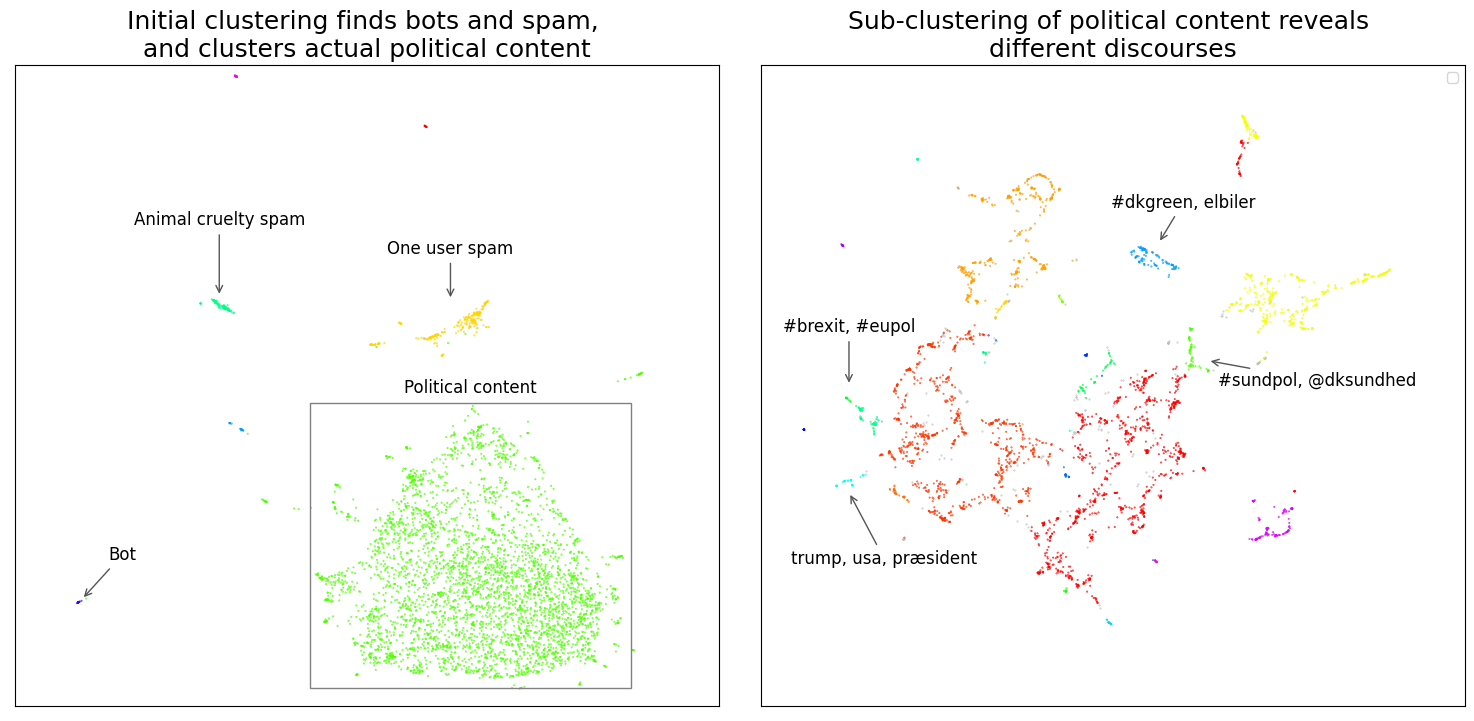

In [ ]:
# Visualize clusters
#fig, ax = plt.subplots(figsize=(7.5, 7.5))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7.5))

# Large Clusters
ax1.set_title('Initial clustering finds bots and spam, \nand clusters actual political content', fontsize=18)
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
ax1.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
ax1.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')

# Adding axis
ax1.axis(xmin=-2.5,xmax=8, ymin=-2.5, ymax =15.5)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)

# Adding rectangle
rect = patches.Rectangle((1.9, -2), 4.8, 8, linewidth=1, edgecolor='grey', facecolor='none')
ax1.add_patch(rect)
ax1.text(4.3, 6.3, 'Political content', ha='center', fontsize=12)

# Annotate cluster
ax1.annotate('Animal cruelty spam', (0.55,9), (0.55,11), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax1.annotate('One user spam', (4, 8.9),(4, 10.2), ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax1.annotate('Bot', (-1.5,0.5), (-0.9,1.6), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)


# Sub clusters
# Visualize clusters
sub_outliers = large_result.loc[large_result.labels == -1, :]
sub_clustered = large_result.loc[large_result.labels != -1, :]
ax2.scatter(sub_outliers.x, sub_outliers.y, color='#BDBDBD', s=0.15)
ax2.scatter(sub_clustered.x, sub_clustered.y, c=sub_clustered.labels, s=0.15, cmap='hsv_r')
ax2.set_title('Sub-clustering of political content reveals \ndifferent discourses', fontsize=18)

# Setting axis limit
ax2.axis(xmin=0,xmax=20, ymin=2, ymax=20)
#ax2.axes.xaxis.set_visible(False)
#ax2.axes.yaxis.set_visible(False)
ax2.legend()

# Annotating clusters
ax2.annotate('Environment', (11.3,15), (12,16), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax2.annotate('Social welfare and healthcare', (12.7,11.7), (15.8,11), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax2.annotate('Brexit and EU', (2.5,11), (2.5,12.5), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)
ax2.annotate('USA', (2.5,8), (3.5,6), 
            ha='center', arrowprops=dict(arrowstyle='->', color='#555555'), fontsize=12)

plt.tight_layout()
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

#plt.savefig('twitter_clustering.png', dpi=300)

In [33]:
with open('data/danish_stopwords.txt') as stop_file:
  stopwords = [word.strip() for word in stop_file.readlines()]

def remove_stopwords(token: str) -> str:
    return token if token not in stopwords else ''

def remove_newlines(text: str) -> str:
    return re.sub(r'\n+', ' ', text)

def remove_numbers(text, str) -> str:
    return re.sub(r'\d+', '', text)


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s{2,}', ' ', text)

import string 
    
def remove_punctuation(text: str) -> str:
    """BUT DO NOT REMOVE HASHTAGS OR MENTIONS"""
    regexp = re.compile(r'([#@]\w+)')
    return text if regexp.search(text) else re.sub(f'[{string.punctuation}]', '', text)


def is_website_token(token: str) -> str:
    if token[:4] == 'http':
        return ''
    else:
        return token

def remove_standalone_numbers(text: str) -> str:
    return re.sub(f'(?<!\S)\d+(?!\S)', '', text)

def split_by_space(text: str) -> List[str]:
    return text.split(' ')

In [ ]:
text

function

In [ ]:
tweet_tokenizer = TweetTokenizer().tokenize
tokenizer = TweetTokenizer()

text_list = list(text.values)

tokenized_text = [[token for token in tokenizer.tokenize(i)] for i in text_list]

print(tokenized_text[:2])

preprocessing_func = [remove_punctuation, str.lower, is_website_token, remove_stopwords, remove_standalone_numbers]

all_tokenizer_text = []

for token_text in tokenized_text:
    post_processed = []
    for token in token_text:
        for function in preprocessing_func:
            token = function(token)
        if token != '':
            post_processed.append(token)
    all_tokenizer_text.append(' '.join(post_processed))

print(all_tokenizer_text[:2])
print(len(all_tokenizer_text))

[['Det', 'er', 'på', 'tide', 'køreprøver', 'kommer', 'i', 'konkurrence', 'og', 'på', 'private', 'hænder', '.', 'Ligesom', 'med', 'bilsyn', '.', 'Væk', 'med', 'ventetider', 'og', 'styrket', 'kvaliteten', '.', '#dkpol', 'https://t.co/YfmAvrkwQu'], ['Min', 'klumme', 'i', '@berlingske', '"', 'I', 'utallige', 'år', ',', 'især', 'op', 'til', 'valgkampe', ',', 'har', 'der', 'været', 'fokus', 'på', 'jobcentrene', 'og', 'beskæftigelsesindsatsen', '.', 'Guld', 'og', 'grønne', 'skove', 'er', 'lovet', ',', 'men', 'alt', 'er', 'lige', 'så', 'gudsforladt', 'og', 'dysfunktionelt', 'som', 'altid', '.', '"', '#dkpol', '#dkmedier', 'https://t.co/GsZjYE2rGl']]
['tide køreprøver konkurrence private hænder bilsyn væk ventetider styrket kvaliteten #dkpol', 'klumme @berlingske utallige år især valgkampe fokus jobcentrene beskæftigelsesindsatsen guld grønne skove lovet gudsforladt dysfunktionelt #dkpol #dkmedier']
4480


In [ ]:
print(len(all_tokenizer_text))
print(len(list(text.values)))

4480
4480


In [ ]:
docs_df = pd.DataFrame(all_tokenizer_text , columns=["Doc"])
docs_df['Original Docs'] = list(text.values)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

#### Group by topic and select a sample

In [ ]:
#docs_df.groupby(['Topic']).filter(lambda group: len(group) > 20).groupby(['Topic']).sample(15).to_json('data/dkpol_large_clusters.json')

### Tf-idf on docs from each cluster

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 3)):
    count = CountVectorizer(tokenizer = split_by_space, stop_words = None, ngram_range = (1,1)).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(200)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
top_n_words

In [ ]:
def save_json(path: Path, container) -> None:
    """write dict to path."""
    print(f"Saving json to {path}")
    with open(path, "w") as outfile:
        json.dump(container, outfile)

In [ ]:
#len(top_n_words)
#top_n_words[5]
#import json
#save_json('data/top_n_words_large_cluster.json', top_n_words)

Saving json to data/top_n_words_large_cluster.json


In [ ]:
# Get topic ids of alle clusters with more than 200 documents
# topic_subset = topic_sizes[topic_sizes.Doc > 100]
# topic_subset = list(topic_subset.Topic.values)

In [ ]:
#print(topic_subset)
#len(top_n_words)
#print(topic_sizes.head(20))
#print(top_n_words.keys())

### Reduce large clusters

In [ ]:
# Cluster largest cluster

# Get large cluster idx
large_cluster_idx = [idx for idx, label in enumerate(cluster.labels_) if label == 5]
large_cluster_embeddings = umap_embeddings[large_cluster_idx,:]

# Reduce dim
large_umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(large_cluster_embeddings)


large_cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(large_umap_embeddings)

print(Counter(large_cluster.labels_))

# Prepare data
large_umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(large_cluster_embeddings)
large_result = pd.DataFrame(large_umap_data, columns=['x', 'y'])
large_result['labels'] = large_cluster.labels_

Counter({28: 944, 27: 846, 23: 740, 25: 411, -1: 250, 5: 116, 12: 107, 16: 81, 20: 67, 17: 42, 1: 38, 14: 33, 26: 32, 24: 26, 13: 22, 6: 20, 11: 18, 21: 17, 2: 17, 9: 16, 22: 16, 10: 16, 15: 16, 18: 15, 7: 14, 8: 14, 3: 13, 19: 12, 4: 12, 0: 12})


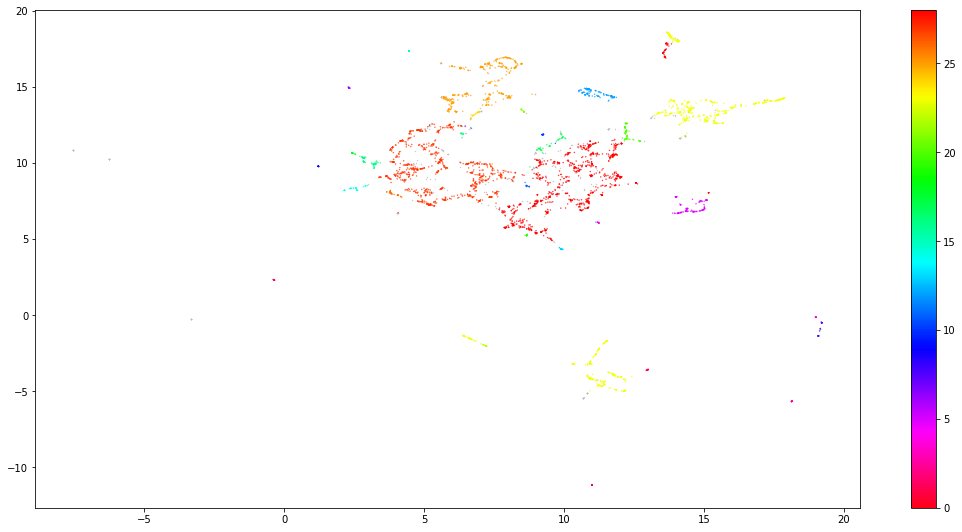

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
sub_outliers = large_result.loc[large_result.labels == -1, :]
sub_clustered = large_result.loc[large_result.labels != -1, :]
plt.scatter(sub_outliers.x, sub_outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(sub_clustered.x, sub_clustered.y, c=sub_clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [ ]:
docs_df = pd.DataFrame([all_tokenizer_text[i] for i in large_cluster_idx] , columns=["Doc"])
docs_df['Original Docs'] = [list(text.values)[i] for i in large_cluster_idx]
docs_df['Topic'] = large_cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_df.groupby(['Topic']).filter(lambda group: len(group) > 20).groupby(['Topic']).sample(15).to_json('data/dkpol_small_subclusters.json')

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
29,28,944
28,27,846
24,23,740
26,25,411
0,-1,250
6,5,116
13,12,107
17,16,81
21,20,67
18,17,42


In [ ]:
top_n_words[12]

[('#dkpol', 0.18675563333140766),
 ('#dkgreen', 0.15551802895617253),
 ('\u2066', 0.04312461822606828),
 ('#dknatur', 0.04144328089404826),
 ('#dkbiz', 0.04121695481995115),
 ('danmark', 0.03642204741333993),
 ('grønne', 0.03485056409649418),
 ('\u2069', 0.031775035841097865),
 ('kød', 0.030751215455465115),
 ('natur', 0.029280890156699588),
 ('giver', 0.028082587585239953),
 ('hånd', 0.02762885392936551),
 ('@mfvmin', 0.026750430816626265),
 ('💚', 0.02674465038283305),
 ('@regeringdk', 0.02633834237427717),
 ('grønt', 0.02440074179724966),
 ('grøn', 0.023024044941137925),
 ('bæredygtig', 0.022299879002958614),
 ('går', 0.021995511096176985),
 ('’', 0.021864992915966403),
 ('🐖', 0.02180482952694262),
 ('@concitoinfo', 0.021058357565497888),
 ('rigtig', 0.020983815337758165),
 ('klar', 0.020815693813031503),
 ('#biodiversitet', 0.020762114875260456),
 ('@koebenhavner', 0.02050081030364341),
 ('håber', 0.020459017779137733),
 ('frem', 0.020411612251241724),
 ('gå', 0.019859397400686166),

In [ ]:
#save_json('data/top_n_words_small_subcluster.json', top_n_words)

Saving json to data/top_n_words_small_subcluster.json
